# Importing the required librairies

In [1]:
import numpy as np
import pandas as pd
import os
import random
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
from torchvision import datasets
from PIL import Image

# Data preprocessing(Visualization the Dataset)

In [2]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/satellite-image-classification/data/cloudy/train_17406.jpg
/kaggle/input/satellite-image-classification/data/cloudy/train_28684.jpg
/kaggle/input/satellite-image-classification/data/cloudy/train_33597.jpg
/kaggle/input/satellite-image-classification/data/cloudy/train_34079.jpg
/kaggle/input/satellite-image-classification/data/cloudy/train_30586.jpg
/kaggle/input/satellite-image-classification/data/cloudy/train_18281.jpg
/kaggle/input/satellite-image-classification/data/cloudy/train_33296.jpg
/kaggle/input/satellite-image-classification/data/cloudy/train_34303.jpg
/kaggle/input/satellite-image-classification/data/cloudy/train_1336.jpg
/kaggle/input/satellite-image-classification/data/cloudy/train_30792.jpg
/kaggle/input/satellite-image-classification/data/cloudy/train_19000.jpg
/kaggle/input/satellite-image-classification/data/cloudy/train_13047.jpg
/kaggle/input/satellite-image-classification/data/cloudy/train_21750.jpg
/kaggle/input/satellite-image-classification/data/cl

**Reading the data in the Input folder**

In [3]:
directory = '/kaggle/input/satellite-image-classification/data/'
files = os.listdir(directory)

for file in files:
    print(file)

cloudy
desert
green_area
water


In [4]:
cloudy_count = len(os.listdir('../input/satellite-image-classification/data/cloudy/'))
desert_count = len(os.listdir('../input/satellite-image-classification/data/desert/'))
green_area_count = len(os.listdir('../input/satellite-image-classification/data/green_area/'))
water_count = len(os.listdir('../input/satellite-image-classification/data/water/'))

print("Number of files in 'cloudy' directory:", cloudy_count)
print("Number of files in 'desert' directory:", desert_count)
print("Number of files in 'green_area' directory:", green_area_count)
print("Number of files in 'water' directory:", water_count)

Number of files in 'cloudy' directory: 1500
Number of files in 'desert' directory: 1131
Number of files in 'green_area' directory: 1500
Number of files in 'water' directory: 1500


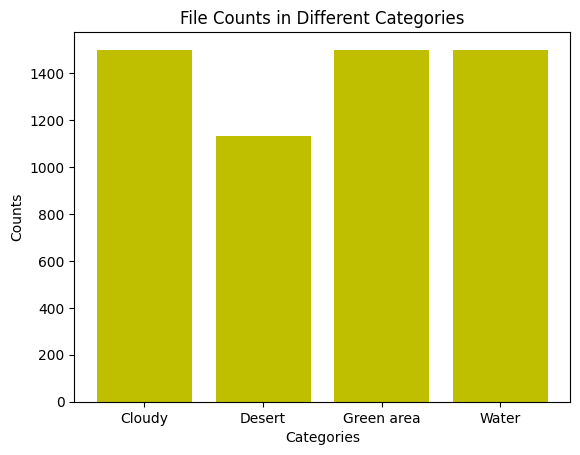

In [5]:
x = ['Cloudy', 'Desert', 'Green area', 'Water']
y = [cloudy_count, desert_count, green_area_count, water_count]

bar_colors = ['y']

plt.bar(x, y, color=bar_colors)
plt.xlabel('Categories')
plt.ylabel('Counts')
plt.title('File Counts in Different Categories')
plt.show()

In [6]:
# Define data transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [7]:
# Load the Kaggle dataset directly
data_dir = '/kaggle/input/satellite-image-classification/data'

# Create a combined dataset for both train and validation
full_dataset = datasets.ImageFolder(root=data_dir, transform=data_transforms['train'])

In [8]:
# Split the combined dataset into train and validation sets
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])

In [9]:
# Create train and validation data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=2)
# Get the dataset sizes and class names
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}
class_names = full_dataset.classes

In [10]:
# Initialize the VGG model
vgg16 = models.vgg16(pretrained=True)
for param in vgg16.parameters():
    param.requires_grad = False

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 262MB/s]


In [11]:
# Modify the fully connected layer to match the number of classes
num_ftrs = vgg16.classifier[6].in_features
vgg16.classifier[6] = nn.Linear(num_ftrs, len(class_names))

In [12]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)

In [13]:
# Train the model
def train_model(model, criterion, optimizer, train_loader, val_loader, dataset_sizes, num_epochs=25):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = train_loader
            else:
                model.eval()
                dataloader = val_loader

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

    return model


In [14]:
# Train the model
model_ft = train_model(vgg16, criterion, optimizer, train_loader, val_loader, dataset_sizes, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.1485 Acc: 0.9492
val Loss: 0.0733 Acc: 0.9796
Epoch 1/24
----------
train Loss: 0.0752 Acc: 0.9776
val Loss: 0.0569 Acc: 0.9849
Epoch 2/24
----------
train Loss: 0.0635 Acc: 0.9798
val Loss: 0.0573 Acc: 0.9805
Epoch 3/24
----------
train Loss: 0.0716 Acc: 0.9749
val Loss: 0.0495 Acc: 0.9849
Epoch 4/24
----------
train Loss: 0.0659 Acc: 0.9791
val Loss: 0.0498 Acc: 0.9831
Epoch 5/24
----------
train Loss: 0.0537 Acc: 0.9827
val Loss: 0.0438 Acc: 0.9867
Epoch 6/24
----------
train Loss: 0.0616 Acc: 0.9787
val Loss: 0.0549 Acc: 0.9849
Epoch 7/24
----------
train Loss: 0.0530 Acc: 0.9811
val Loss: 0.0361 Acc: 0.9885
Epoch 8/24
----------
train Loss: 0.0485 Acc: 0.9853
val Loss: 0.0329 Acc: 0.9894
Epoch 9/24
----------
train Loss: 0.0475 Acc: 0.9829
val Loss: 0.0379 Acc: 0.9885
Epoch 10/24
----------
train Loss: 0.0460 Acc: 0.9836
val Loss: 0.0385 Acc: 0.9885
Epoch 11/24
----------
train Loss: 0.0443 Acc: 0.9827
val Loss: 0.0359 Acc: 0.9911
Epoch 12/24
--

In [15]:
# save model
torch.save(model_ft.state_dict(), 'VGG16_trained_model.pth')

# Plot the Training and Validation Data

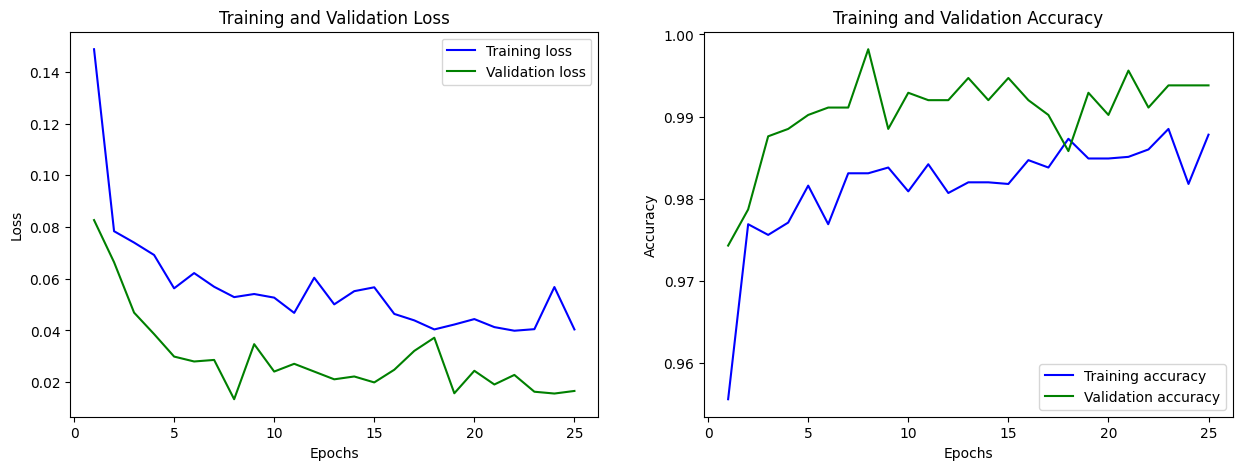

In [16]:
# Training and Validation Data
train_loss = [0.1488, 0.0784, 0.0740, 0.0692, 0.0563, 0.0622, 0.0569, 0.0529, 0.0541, 0.0527, 0.0468, 0.0604, 0.0501, 0.0552, 0.0567, 0.0464, 0.0439, 0.0404, 0.0423, 0.0444, 0.0413, 0.0399, 0.0405, 0.0568, 0.0404]
val_loss = [0.0827, 0.0664, 0.0469, 0.0386, 0.0299, 0.0280, 0.0286, 0.0134, 0.0347, 0.0241, 0.0271, 0.0241, 0.0211, 0.0222, 0.0199, 0.0248, 0.0321, 0.0372, 0.0157, 0.0244, 0.0191, 0.0228, 0.0163, 0.0156, 0.0166]
train_acc = [0.9556, 0.9769, 0.9756, 0.9771, 0.9816, 0.9769, 0.9831, 0.9831, 0.9838, 0.9809, 0.9842, 0.9807, 0.9820, 0.9820, 0.9818, 0.9847, 0.9838, 0.9873, 0.9849, 0.9849, 0.9851, 0.9860, 0.9885, 0.9818, 0.9878]
val_acc = [0.9743, 0.9787, 0.9876, 0.9885, 0.9902, 0.9911, 0.9911, 0.9982, 0.9885, 0.9929, 0.9920, 0.9920, 0.9947, 0.9920, 0.9947, 0.9920, 0.9902, 0.9858, 0.9929, 0.9902, 0.9956, 0.9911, 0.9938, 0.9938, 0.9938]

# Plotting the graph
epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(15, 5))

# Plotting Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'g', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

**Based on the training output, we can see the following:**

Loss Decrease: Both training and validation loss generally decrease as the number of epochs increases.  This indicates that the model is learning and improving its performance over time.

Accuracy Increase: Training and validation accuracy generally increase as the number of epochs increases.  This suggests that the model is becoming more accurate in its predictions as it undergoes further training.

Overfitting: There might be a slight indication of overfitting as the training accuracy is consistently higher than the validation accuracy, especially in the later epochs.  However, the margin between the training and validation accuracy is not substantial, indicating that the model's overfitting is relatively well-controlled.

Stabilization: Towards the later epochs, the rate of improvement in both loss and accuracy seems to stabilize, suggesting that the model is approaching its optimal performance.

**Overall, the training process appears to be progressing well, with the model improving in both loss and accuracy as the number of epochs increases.**

# Testing the Model

In [17]:
# Test the trained model
def test_model(model, test_loader):
    correct = 0
    total = 0
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.eval()

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    print('Accuracy on the test set: {}%'.format(100 * accuracy))

test_loader = torch.utils.data.DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=2)
test_model(model_ft, test_loader)

Accuracy on the test set: 99.02395740905058%


**My model achieved an accuracy of 99% on the test set. This indicates that the model performs very well and has learned to classify images with high accuracy.**

# Apply the trained model

**Apply the trained model to predicted the randomly selected image**

In [18]:
# Create a new model instance
model = models.vgg16(pretrained=False)

# Print model structure
print(model)

# Load weight
checkpoint = torch.load('VGG16_trained_model.pth')
print(checkpoint.keys())  # 打印加载的权重结构

# Print the model layer by layer and load the weights, compare their structure
for name, param in model.named_parameters():
    print(name, param.size())  # Print the name and size of the model parameters

for key in checkpoint:
    print(key, checkpoint[key].size()) # Print the key and size of the loaded weight


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

**Randomly choose one picture from 4 different classes folder**

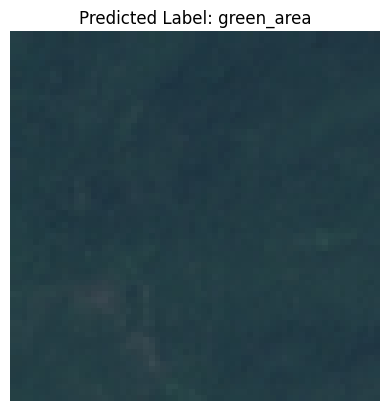

Selected Image Path: /kaggle/input/satellite-image-classification/data/green_area/Forest_2872.jpg


In [19]:
# Define the class names
class_names = ['cloudy', 'desert', 'green_area', 'water']

# Load the trained VGG16 model
model = models.vgg16(pretrained=False)
model.classifier[6] = nn.Linear(4096, len(class_names))  # Assuming the last fully connected layer has been modified during fine-tuning
model.load_state_dict(torch.load('VGG16_trained_model.pth'))
model.eval()

# Define the transform for the test image
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Select a random image file
category = random.choice(['cloudy', 'desert', 'green_area', 'water'])
image_path = f'/kaggle/input/satellite-image-classification/data/{category}'
image_file = random.choice(os.listdir(image_path))
image = Image.open(os.path.join(image_path, image_file))

# Preprocess the image
input_image = transform(image).unsqueeze(0)

# Perform inference on the image
with torch.no_grad():
    outputs = model(input_image)
    _, predicted_class = torch.max(outputs, 1)

# Get the predicted class label
predicted_label = class_names[predicted_class.item()]

# Display the image and the predicted label
plt.imshow(np.array(image))
plt.axis('off')
plt.title(f'Predicted Label: {predicted_label}')
plt.show()
print("Selected Image Path:", os.path.join(image_path, image_file))


**The following code will create a 3x3 sub screen grid, with each sub screen displaying a randomly selected image and its predicted category.**


***In this way, We can visually predict images and their names and locations in folders.***

**Randomly choose one folder file's image to predict the label**

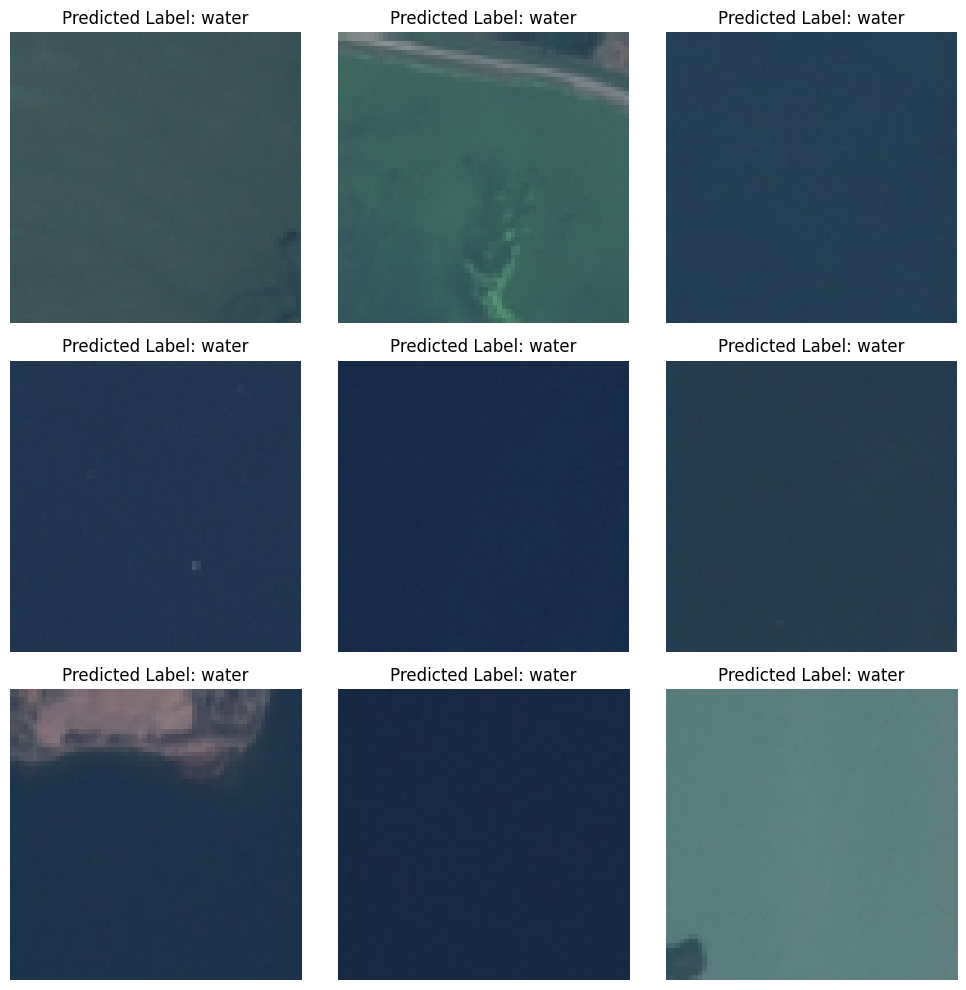

In [20]:
# Define the class names
class_names = ['cloudy', 'desert', 'green_area', 'water']

# Load the trained VGG16 model
model = models.vgg16(pretrained=False)
model.classifier[6] = nn.Linear(4096, len(class_names))  # Assuming the last fully connected layer has been modified during fine-tuning
model.load_state_dict(torch.load('VGG16_trained_model.pth'))
model.eval()

# Define the transform for the test image
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Select 9 random image files
category = random.choice(['cloudy', 'desert', 'green_area', 'water'])
image_path = f'/kaggle/input/satellite-image-classification/data/{category}'
image_files = random.sample(os.listdir(image_path), 9)

# Create a 3x3 grid for displaying the images
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

for i, ax in enumerate(axes.flatten()):
    # Open and preprocess the image
    image = Image.open(os.path.join(image_path, image_files[i]))
    input_image = transform(image).unsqueeze(0)

    # Perform inference on the image
    with torch.no_grad():
        outputs = model(input_image)
        _, predicted_class = torch.max(outputs, 1)

    # Get the predicted class label
    predicted_label = class_names[predicted_class.item()]

    # Display the image and the predicted label
    ax.imshow(np.array(image))
    ax.axis('off')
    ax.set_title(f'Predicted Label: {predicted_label}')

# Adjust spacing between subplots
plt.tight_layout()

# Show the grid of images
plt.show()

**Randomly choose four classes folder's images to predeict the label**

In [21]:
import random
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
random.seed(12)
np.random.seed(12)
torch.manual_seed(12)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

def load_model():
    # Define the class names
    class_names = ['cloudy', 'desert', 'green_area', 'water']

    # Load the trained VGG16 model
    model = models.vgg16(pretrained=False)
    model.classifier[6] = nn.Linear(4096, len(class_names))
    model.load_state_dict(torch.load('VGG16_trained_model.pth'))
    model.eval()

    return model, class_names

def preprocess_image(image_path, transform):
    # Open and preprocess the image
    image = Image.open(image_path).convert('RGB')  # Convert to RGB mode
    input_image = transform(image).unsqueeze(0)
    return input_image


def main():
    # Load the model and class names
    model, class_names = load_model()

    # Define the transform for the test image
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Create a 3x3 grid for displaying the images
    fig, axes = plt.subplots(3, 3, figsize=(8, 8))

    for ax in axes.flatten():
        # Select a random category for each group of 9 images
        category = random.choice(['cloudy', 'desert', 'green_area', 'water'])
        image_path = f'/kaggle/input/satellite-image-classification/data/{category}'
        image_file = random.choice(os.listdir(image_path))

        # Preprocess the image
        input_image = preprocess_image(os.path.join(image_path, image_file), transform)

        # Perform inference on the image
        with torch.no_grad():
            outputs = model(input_image)
            _, predicted_class = torch.max(outputs, 1)

        # Get the predicted class label
        predicted_label = class_names[predicted_class.item()]

        # Display the image and predicted label
        image = Image.open(os.path.join(image_path, image_file))
        ax.imshow(np.array(image))
        ax.axis('off')
        ax.set_title(f'Predicted Label: {predicted_label}')

    # Adjust spacing between subplots
    plt.tight_layout()

    # Show the grid of images
    plt.show()

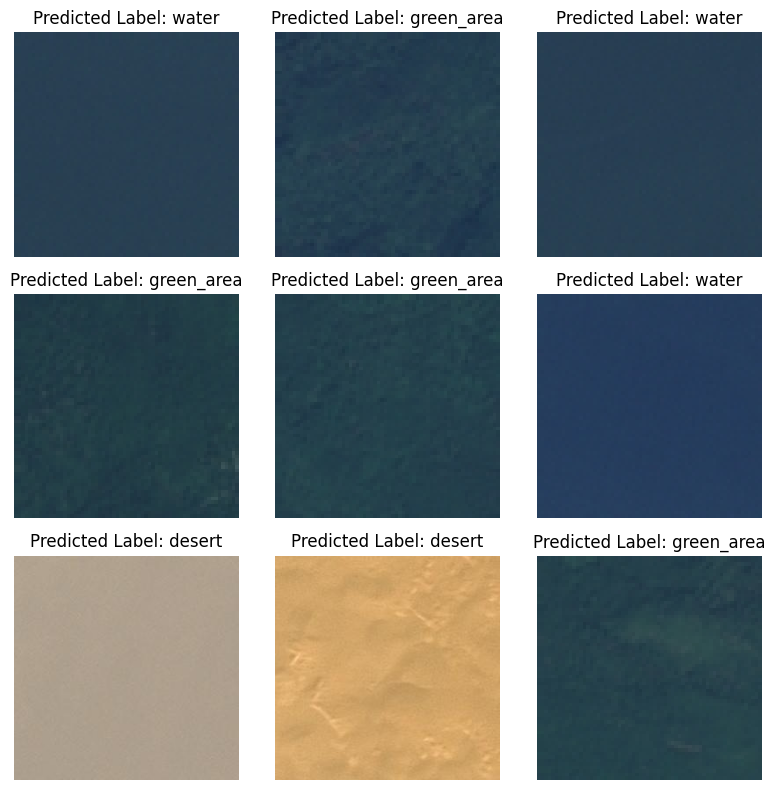

In [22]:
if __name__ == '__main__':
    main()